Tutorial 4: 3D motion estimation, Script for Image Rendering,<br>
Practical Course: Learning For Self-Driving Cars and Intelligent
Systems, Winter Semester 2021/22,<br>
Technical University of Munich,<br>
Organizers: Qadeer Khan, Mariia Gladkova<br>
https://vision.in.tum.de/teaching/ws2021/intellisys_ws2021<br>

In [39]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
import torch
from skimage import io
import os
import json
import copy
import glob
import cv2
import open3d as o3d
from PIL import Image

import torch.nn.functional as F
import torch
from tqdm import tqdm
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
import math
import os
os.chdir('../..')
from torch.utils.data import Dataset, DataLoader
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    PointsRasterizationSettings,
    OpenGLPerspectiveCameras,
    SfMPerspectiveCameras,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)


#FOLDER = "/storage/group/intellisys/datasets/carla/3d_motion/moving/episode_000/"
FOLDER = "/home/changyao/Carla_0.9.11/PythonAPI/examples/"

In [40]:
def read_rgb(rgb_file):
    rgb = io.imread(rgb_file)
    #plt.imshow(rgb)
    #plt.title(rgb_file)
    #plt.show()
    return rgb

def read_depth(depth_file):
    depth = io.imread(depth_file)
    # Reference: https://carla.readthedocs.io/en/stable/cameras_and_sensors/#camera-depth-map
    depth = depth[:, :, 0] * 1.0 + depth[:, :, 1] * 256.0 + depth[:, :, 2] * (256.0 * 256)
    depth = depth * (1/ (256 * 256 * 256 - 1))
    return depth

def point_cloud_to_image(points,color , K, width=512, height=512, transformation = None):
    points = np.transpose(points, (1,0))
    if transformation is not None:
        tmp = np.ones((4,points.shape[1]))
        tmp[:3,:] = points
        tmp = transformation @ tmp
    else:
        tmp = points
        
    tmp = K @ tmp
    tmp1 = tmp/tmp[2,:]
    # TODO:
    # Note that multiple points might be mapped to the same pixel
    # The one with the lowest depth value should be assigned to that pixel
    # However, note this has not been implemented here
    # This needs to be implemented
    u_cord = np.clip(np.round(tmp1[0,:]),0,width - 1).astype(np.int32)
    v_cord = np.clip(np.round(tmp1[1,:]),0,height - 1).astype(np.int32)
    imtmp = np.zeros((height,width,3)).astype(np.uint8)
    imtmp[v_cord, u_cord,:]= (color).astype(np.uint8)

    plt.imshow(imtmp)
    plt.show() 
    
    
def get_rendered_image(depth, img, rel_pose12, K):
    
    rel_pose12 = rel_pose12.copy()
    rel_pose12[0:2,3] *= -1
    angles = rotationMatrixToEulerAngles(rel_pose12[:3,:3])
    rel_pose12[:3,:3] = eulerAnglesToRotationMatrix(angles * np.array([1.0,1.0,-1.0]))

    verts, color = depth_to_local_point_cloud(depth, color=img,k = K)
    
    # See also: 
    # https://github.com/facebookresearch/pytorch3d/blob/stable/docs/tutorials/render_colored_points.ipynb
    
    verts = torch.Tensor(verts).to(device)
    rgb = torch.Tensor(color).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    

    
    R = torch.from_numpy(rel_pose12[:3,:3].astype(np.float32)).unsqueeze(0)
    T = torch.FloatTensor(1*rel_pose12[:3,3].astype(np.float32)).unsqueeze(0)
    cameras = SfMPerspectiveCameras(device=device, R=R, T=T,
                                        focal_length = torch.FloatTensor([[1,1]]),
                                       principal_point = torch.FloatTensor([[0,0]]))

    raster_settings = PointsRasterizationSettings(
            image_size=img.shape[0], 
            radius = 0.01,
            points_per_pixel = 100
        )

    renderer = PointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
            compositor=AlphaCompositor()
        )

    images = renderer(point_cloud)
    return images[0, ..., :3].cpu().numpy()


def depth_to_local_point_cloud(image, color=None, k = np.eye(3),max_depth=1.1):
    """
    Convert an image containing CARLA encoded depth-map to a 2D array containing
    the 3D position (relative to the camera) of each pixel and its corresponding
    RGB color of an array.
    "max_depth" is used to omit the points that are far enough.
    Reference: 
    https://github.com/carla-simulator/driving-benchmarks/blob/master/version084/carla/image_converter.py
    """
    far = 1000.0  # max depth in meters.
    normalized_depth = image# depth_to_array(image)
    height, width = image.shape


    # 2d pixel coordinates
    pixel_length = width * height
    u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
    v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)
    if color is not None:
        color = color.reshape(pixel_length, 3)
    normalized_depth = np.reshape(normalized_depth, pixel_length)

    # Search for pixels where the depth is greater than max_depth to
    # delete them
    max_depth_indexes = np.where(normalized_depth > max_depth)
    normalized_depth = np.delete(normalized_depth, max_depth_indexes)
    u_coord = np.delete(u_coord, max_depth_indexes)
    v_coord = np.delete(v_coord, max_depth_indexes)
    if color is not None:
        color = np.delete(color, max_depth_indexes, axis=0)

    # pd2 = [u,v,1]
    p2d = np.array([u_coord, v_coord, np.ones_like(u_coord)])

    # P = [X,Y,Z]
    p3d = np.dot(np.linalg.inv(k), p2d)
    p3d *= normalized_depth * far
    p3d = np.transpose(p3d, (1,0))
    return p3d, color / 255.0

Reference: https://learnopencv.com/rotation-matrix-to-euler-angles/

In [41]:
def isRotationMatrix(R) :
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

def rotationMatrixToEulerAngles(R) :

    assert(isRotationMatrix(R))
    
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
    
    singular = sy < 1e-6

    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0

    return np.array([x, y, z])*180/np.pi

# Calculates Rotation Matrix given euler angles.
def eulerAnglesToRotationMatrix(theta) :
    
    theta *= np.pi / 180
    
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
        
        
                    
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])
                
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
                    
                    
    R = np.dot(R_x, np.dot( R_y, R_z ))

    return R

Example showing how image rendering works (similar to Task1)

In [42]:
FOLDER = "/home/changyao/Carla_0.9.11/PythonAPI/examples/output/on_trajectory/"
#[image, x_ref, y_ref, yaw_ref, v_ref, x_ego, y_ego, yaw_ego, v_ego, throttle_ref, str_ref, throttle_ego, str_ego]
state_ref = []
state_ego = []
control_ref = []
fh = open(FOLDER + 'data.txt', 'r')   
for line in fh:             
    line = line.rstrip()     
    words = line.split()   
    state_ref.append([float(words[1]), float(words[2]), float(words[3]), float(words[4])]) 
    state_ego.append([float(words[5]), float(words[6]), float(words[7]), float(words[8])]) 
    control_ref.append([float(words[11]), float(words[12])]) 
print(len(state_ref))
# frame 0-799

800


[[200.   0. 200.]
 [  0. 200. 200.]
 [  0.   0.   1.]]
noise theta: 0.0
original view


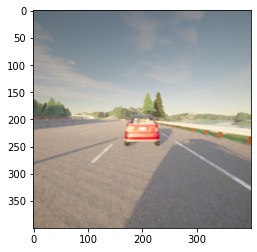

(160000, 3)
Point Cloud 1, projected back to image 2


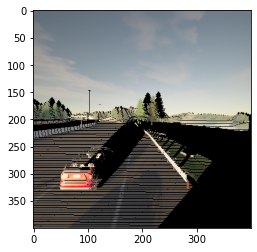

Rendered Image from Image 1


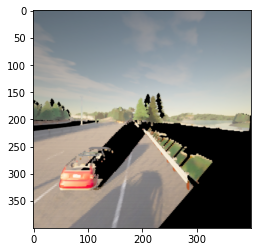

Difference between rendered image and image 2


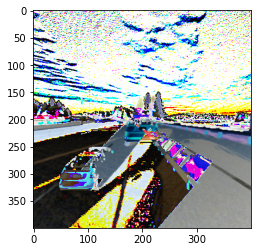

In [84]:
%matplotlib inline
FOLDER = "/home/changyao/Carla_0.9.11/PythonAPI/examples/output/on_trajectory/" 
# camera position
delta_x = 1.8
delta_y = 0
delta_z = 1.3 
frame  = 510 
 
rgb_file    = os.path.join(FOLDER, "RGB/%04d.png" % frame) 
depth_file  = os.path.join(FOLDER, "DepthMap/%04d.png" % frame)

intrinsics_file = os.path.join(FOLDER,"camera_intrinsic.json") 

with open(intrinsics_file) as f:
    K = json.load(f)
K = np.array(K)
print(K)

x1, y1, theta1, v1 =  state_ego[frame - 1]
G1 = np.array([[np.cos(theta1), -np.sin(theta1), 0,  x1 + delta_x], 
               [np.sin(theta1), np.cos(theta1), 0, y1 + delta_y],
               [0, 0, 1, 0 + delta_z],
               [0, 0, 0, 1]])

noise_x = -0.0 #np.random.uniform(-1.0, 1.0) left:>0, right:<0
noise_y = 3
noise_z = 0.0
noise_theta = -0 * np.pi / 180 # left:<0,right:>0
print('noise theta:', noise_theta)
G2 = np.array([[np.cos(theta1), -np.sin(theta1), 0,  x1 + delta_x + noise_x], 
               [np.sin(theta1), np.cos(theta1), 0, y1 + delta_y + noise_y],
               [0, 0, 1, 0 + delta_z + noise_z],
               [0, 0, 0, 1]])
rot = np.array([[np.cos(noise_theta), 0, np.sin(noise_theta), 0], 
               [0, 1, 0, 0],
               [-np.sin(noise_theta), 0, np.cos(noise_theta), 0],
               [0, 0, 0, 1]])

rel_pose12 = np.linalg.inv(G2 @ rot) @ (G1) # transformation of camera2(with bias) wrt camera1(ego-vehicle on trajectory)


rgb = read_rgb(rgb_file)[:, :, :3]
print('original view')
plt.imshow(rgb)
plt.show()
depth = read_depth(depth_file)


# Moving Point cloud from Image1 to Frame of reference of Image2
height, width = depth.shape


pixel_length = width * height
u_coord = repmat(np.r_[width-1:-1:-1],
                     height, 1).reshape(pixel_length)
v_coord = repmat(np.c_[height-1:-1:-1],
                     1, width).reshape(pixel_length)

depths = depth[v_coord, u_coord] * 1000
color = rgb[v_coord, u_coord] 
print(color.shape)

# Remove points greater than 50 meters   
max_depth_indexes = np.where(depths > 1000)
depths = np.delete(depths, max_depth_indexes)
color = np.delete(color, max_depth_indexes, axis = 0)
u_coord = np.delete(u_coord, max_depth_indexes)
v_coord = np.delete(v_coord, max_depth_indexes)


homogenous = np.vstack((u_coord, v_coord, np.ones_like(u_coord)))
p3d = np.linalg.inv(K) @ (homogenous*depths)
pc1InRef2 = (rel_pose12 @ np.vstack((p3d, np.ones_like(u_coord))))[:3,:]

print("Point Cloud 1, projected back to image 2")
point_cloud_to_image(pc1InRef2.T,color ,K, width, height,transformation = None)

print("Rendered Image from Image 1")


rendered_image = (get_rendered_image(depth, rgb, rel_pose12, K) * 255).astype(np.uint8)
#print(rendered_image)
plt.imshow(rendered_image)
plt.show()

print("Difference between rendered image and image 2")
diff = np.abs(rendered_image - rgb)
plt.imshow(diff)
plt.show()
    

In [76]:
def center_crop(img, dim):
    """Returns center cropped image
    Args:
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped
    """
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img


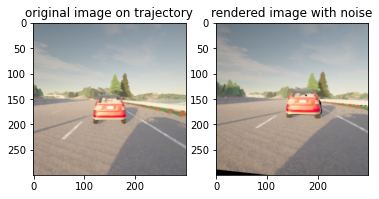

In [82]:
plt.subplot(1,2,1)
plt.title('original image on trajectory')
plt.imshow(center_crop(rgb, (300,300)))
plt.subplot(1,2,2)
plt.title('rendered image with noise')
plt.imshow(center_crop(rendered_image, (300,300)))